In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print("Library Versions:")
print('numpy:',np.__version__)
print('pandas:',pd.__version__)
print('tensorflow:',tf.__version__)
print('tensorflow probability:', tfp.__version__)

2023-10-06 20:39:42.511371: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-06 20:39:42.575767: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-06 20:39:43.888147: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Library Versions:
numpy: 1.26.0
pandas: 2.1.1
tensorflow: 2.13.1
tensorflow probability: 0.21.0


In [2]:

n_epochs = 200
verbose_option = True

# Regression for Naval Plant Maintenance

Load regression dataset

In [3]:
npm = pd.read_csv('navalplantmaintenance.csv',header=None)
npm

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1.14,3.0,290.0,1350.0,6680.0,7.58,7.58,464.0,288.0,551.0,1.10,0.998,5.95,1.02,7.14,0.082,0.95,0.975
1,2.09,6.0,6960.0,1380.0,6830.0,28.20,28.20,635.0,288.0,582.0,1.33,0.998,7.28,1.02,10.70,0.287,0.95,0.975
2,3.14,9.0,8380.0,1390.0,7110.0,60.40,60.40,606.0,288.0,588.0,1.39,0.998,7.57,1.02,13.10,0.259,0.95,0.975
3,4.16,12.0,14700.0,1550.0,7790.0,114.00,114.00,661.0,288.0,614.0,1.66,0.998,9.01,1.02,18.10,0.358,0.95,0.975
4,5.14,15.0,21600.0,1920.0,8490.0,175.00,175.00,731.0,288.0,646.0,2.08,0.998,11.20,1.03,26.40,0.522,0.95,0.975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11929,5.14,15.0,21600.0,1920.0,8470.0,175.00,175.00,682.0,288.0,629.0,2.09,0.998,11.00,1.03,23.80,0.471,1.00,1.000
11930,6.18,18.0,29800.0,2310.0,8800.0,246.00,246.00,747.0,288.0,659.0,2.51,0.998,13.10,1.03,32.70,0.647,1.00,1.000
11931,7.15,21.0,39000.0,2680.0,9120.0,332.00,332.00,796.0,288.0,680.0,2.98,0.998,15.40,1.04,42.10,0.834,1.00,1.000
11932,8.21,24.0,51000.0,3090.0,9300.0,438.00,438.00,893.0,288.0,722.0,3.59,0.998,18.30,1.04,58.10,1.150,1.00,1.000


Split dataset into training and test datasets

In [4]:
npm_train, npm_test = train_test_split(npm,test_size=0.25,random_state=42)

Create the training and test input matrices using the first 16 columns and the training and test target matrices using the 18th columns.

In [5]:
npm_train_np = npm_train.to_numpy()
npm_test_np = npm_test.to_numpy()
x_train_np = npm_train_np[:,:16]
x_test_np = npm_test_np[:,:16]
y_train_np = npm_train_np[:,17]
y_test_np = npm_test_np[:,17]

Z-score the input and output data using the training dataset statistics

In [6]:
x_mu = x_train_np.mean(axis=0)
x_sigma = x_train_np.std(axis=0)
y_mu=y_train_np.mean(axis=0)
y_sigma=y_train_np.std(axis=0)

In [7]:
def scale(x,x_mu,x_sigma):
  x_sigma += 1e-16
  return (x-x_mu)/x_sigma

In [8]:
def unscale(x,x_mu,x_sigma):
  x_sigma += 1e-16
  return x_sigma*x+x_mu

In [9]:
x_train_np_z = scale(x_train_np,x_mu,x_sigma)
y_train_np_z = scale(y_train_np,y_mu,y_sigma)
x_test_np_z = scale(x_test_np,x_mu,x_sigma)
y_test_np_z = scale(y_test_np,y_mu,y_sigma)

Using Tensoflow, perform non-linear regression.

In [10]:
loss_object = tf.keras.losses.MeanSquaredError()

In [11]:
input = tf.keras.layers.Input(16)
h1 = tf.keras.layers.Dense(50, activation=tf.keras.activations.relu, name="hidden1")(input)
h2 = tf.keras.layers.Dense(50, activation=tf.keras.activations.relu, name="hidden2")(h1)
m = tf.keras.layers.Dense(1, name="mu")(h2)
model = tf.keras.Model(inputs=input, outputs=m)

model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.1), loss=loss_object)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16)]              0         
                                                                 
 hidden1 (Dense)             (None, 50)                850       
                                                                 
 hidden2 (Dense)             (None, 50)                2550      
                                                                 
 mu (Dense)                  (None, 1)                 51        
                                                                 
Total params: 3451 (13.48 KB)
Trainable params: 3451 (13.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


2023-10-06 20:39:47.770450: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46497 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:1a:00.0, compute capability: 8.9


In [12]:
# Training
model.fit(x_train_np_z, y_train_np_z, epochs=n_epochs, verbose=verbose_option)

Epoch 1/200


2023-10-06 20:39:50.189068: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-06 20:39:50.216283: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd57fa066f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-06 20:39:50.216325: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2023-10-06 20:39:50.481319: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-06 20:39:50.750602: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


280/280 [==============================] - 3s 2ms/step - loss: 0.9992
Epoch 2/200
280/280 [==============================] - 1s 2ms/step - loss: 0.9426
Epoch 3/200
280/280 [==============================] - 1s 2ms/step - loss: 0.8783
Epoch 4/200
280/280 [==============================] - 1s 2ms/step - loss: 0.8148
Epoch 5/200
280/280 [==============================] - 1s 2ms/step - loss: 0.7753
Epoch 6/200
280/280 [==============================] - 1s 2ms/step - loss: 0.7297
Epoch 7/200
280/280 [==============================] - 1s 2ms/step - loss: 0.6925
Epoch 8/200
280/280 [==============================] - 1s 2ms/step - loss: 0.6817
Epoch 9/200
280/280 [==============================] - 1s 2ms/step - loss: 0.6507
Epoch 10/200
280/280 [==============================] - 1s 2ms/step - loss: 0.6248
Epoch 11/200
280/280 [==============================] - 1s 2ms/step - loss: 0.5982
Epoch 12/200
280/280 [==============================] - 1s 2ms/step - loss: 0.5942
Epoch 13/200
280/280 [===

Epoch 100/200
280/280 [==============================] - 1s 2ms/step - loss: 0.1738
Epoch 101/200
280/280 [==============================] - 1s 2ms/step - loss: 0.1636
Epoch 102/200
280/280 [==============================] - 1s 2ms/step - loss: 0.1540
Epoch 103/200
280/280 [==============================] - 1s 2ms/step - loss: 0.1467
Epoch 104/200
280/280 [==============================] - 1s 2ms/step - loss: 0.1600
Epoch 105/200
280/280 [==============================] - 1s 2ms/step - loss: 0.1519
Epoch 106/200
280/280 [==============================] - 1s 2ms/step - loss: 0.1589
Epoch 107/200
280/280 [==============================] - 1s 2ms/step - loss: 0.1370
Epoch 108/200
280/280 [==============================] - 1s 2ms/step - loss: 0.1619
Epoch 109/200
280/280 [==============================] - 1s 2ms/step - loss: 0.1481
Epoch 110/200
280/280 [==============================] - 1s 2ms/step - loss: 0.1603
Epoch 111/200
280/280 [==============================] - 1s 2ms/step - loss:

280/280 [==============================] - 1s 2ms/step - loss: 0.0825
Epoch 198/200
280/280 [==============================] - 1s 2ms/step - loss: 0.0930
Epoch 199/200
280/280 [==============================] - 1s 2ms/step - loss: 0.0809
Epoch 200/200
280/280 [==============================] - 1s 2ms/step - loss: 0.0844


Compute the Mean Squared Error (MSE) for the trained non-linear homoscedastic regression model for the test data

In [13]:
y_test_pred_z = model(x_test_np_z)
y_test_pred = unscale(y_test_pred_z,y_mu,y_sigma) #TODO: Calculate the un-z-scored predicted mean
print('MSE:', mean_squared_error(y_test_np, y_test_pred.numpy()))

MSE: 4.454219990513917e-06


1. Create white-box, untargeted FGSM adversarial examples for the test set for the non-linear regression model.

In [14]:
def create_adversarial_pattern(model,input_example, target,loss_object):
    input_example = tf.convert_to_tensor(input_example)
    with tf.GradientTape() as tape:
        tape.watch(input_example)
        prediction = model(input_example) 
        loss = loss_object(target, prediction) 

        # Get the gradients of the loss w.r.t to the input example.
        gradient = tape.gradient(loss, input_example)
        # Get the sign of the gradients to create the perturbation
        signed_grad = tf.sign(gradient)
    return signed_grad

In [15]:
signed_grad_np_z = np.zeros(shape=x_test_np_z.shape)
for i in range(x_test_np_z.shape[0]):
    signed_grad_np_z[i] = create_adversarial_pattern(model, np.reshape(x_test_np_z[i], [1,-1]), y_test_np_z[i], loss_object)

2. Compute the Mean Squared Error (MSE) for the trained non-linear regression model for the white-box, untargeted FGSM adversarial examples using:
- Epsilon = 0.01
- Epsilon= 0.1
- Epsilon = 1.

In [16]:
for eps in [0.01,0.1,1.]:
    y_test_pred_z = model(x_test_np_z+eps*signed_grad_np_z)
    y_test_pred = unscale(y_test_pred_z,y_mu,y_sigma) #TODO: Calculate the un-z-scored predicted mean
    print('MSE for Epsilon = ' + str(eps)+':', mean_squared_error(y_test_np, y_test_pred.numpy()))

MSE for Epsilon = 0.01: 6.0206313974842456e-05
MSE for Epsilon = 0.1: 0.0018554663208178684
MSE for Epsilon = 1.0: 0.15482808551042987


# Classification for Ship Detection


Load Ship Detection Dataset

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

ROOT_PATH = "shipsnet"
LR = 1e-3
BATCH_SIZE=1000

def normalize_img(image, label):
    return (tf.cast(image, tf.float32) / 255.0, label)

# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
train_dataset, test_dataset = tf.keras.utils.image_dataset_from_directory(ROOT_PATH,
                            labels = 'inferred',
                            label_mode = 'binary',
                            class_names = None,
                            color_mode = "rgb",
                            batch_size = BATCH_SIZE,
                            image_size = (80, 80),
                            shuffle = True,
                            seed = 42,
                            subset="both",
                            validation_split = 0.2,
)

train_dataset = train_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache()
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

Found 4000 files belonging to 2 classes.
Using 3200 files for training.
Using 800 files for validation.


Using Tensoflow, perform  non-linear binary classification model for the classification dataset.

In [18]:
inputs = layers.Input(shape=(80,80,3))
flat = layers.Flatten()(inputs)
h1 = layers.Dense(50, activation="relu")(flat)
h2 = layers.Dense(50, activation="relu")(h1)
h3 = layers.Dense(50, activation="relu")(h2)
p = layers.Dense(1,activation=tf.keras.activations.sigmoid)(h3)

model = keras.Model(inputs=inputs, outputs=p)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(LR),
    metrics=[tf.keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.BinaryCrossentropy(from_logits=False)]
)

In [19]:
model.fit(train_dataset, epochs=n_epochs, verbose=True)

Epoch 1/200


2023-10-06 20:42:01.330705: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


4/4 [==============================] - 4s 18ms/step - loss: 1.4888 - binary_accuracy: 0.4391 - binary_crossentropy: 1.4888
Epoch 2/200
4/4 [==============================] - 0s 16ms/step - loss: 1.2229 - binary_accuracy: 0.7572 - binary_crossentropy: 1.2229
Epoch 3/200
4/4 [==============================] - 0s 16ms/step - loss: 0.6318 - binary_accuracy: 0.7606 - binary_crossentropy: 0.6318
Epoch 4/200
4/4 [==============================] - 0s 16ms/step - loss: 0.5510 - binary_accuracy: 0.7628 - binary_crossentropy: 0.5510
Epoch 5/200
4/4 [==============================] - 0s 16ms/step - loss: 0.5464 - binary_accuracy: 0.7625 - binary_crossentropy: 0.5464
Epoch 6/200
4/4 [==============================] - 0s 16ms/step - loss: 0.5054 - binary_accuracy: 0.7822 - binary_crossentropy: 0.5054
Epoch 7/200
4/4 [==============================] - 0s 16ms/step - loss: 0.4909 - binary_accuracy: 0.7775 - binary_crossentropy: 0.4909
Epoch 8/200
4/4 [==============================] - 0s 16ms/step - l

4/4 [==============================] - 0s 16ms/step - loss: 0.1985 - binary_accuracy: 0.9222 - binary_crossentropy: 0.1985
Epoch 62/200
4/4 [==============================] - 0s 16ms/step - loss: 0.2032 - binary_accuracy: 0.9184 - binary_crossentropy: 0.2032
Epoch 63/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1927 - binary_accuracy: 0.9234 - binary_crossentropy: 0.1927
Epoch 64/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1918 - binary_accuracy: 0.9225 - binary_crossentropy: 0.1918
Epoch 65/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1900 - binary_accuracy: 0.9194 - binary_crossentropy: 0.1900
Epoch 66/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1823 - binary_accuracy: 0.9272 - binary_crossentropy: 0.1823
Epoch 67/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1752 - binary_accuracy: 0.9297 - binary_crossentropy: 0.1752
Epoch 68/200
4/4 [==============================] - 0s 16ms/s

4/4 [==============================] - 0s 16ms/step - loss: 0.1748 - binary_accuracy: 0.9297 - binary_crossentropy: 0.1748
Epoch 122/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1690 - binary_accuracy: 0.9319 - binary_crossentropy: 0.1690
Epoch 123/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1665 - binary_accuracy: 0.9341 - binary_crossentropy: 0.1665
Epoch 124/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1683 - binary_accuracy: 0.9328 - binary_crossentropy: 0.1683
Epoch 125/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1745 - binary_accuracy: 0.9291 - binary_crossentropy: 0.1745
Epoch 126/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1825 - binary_accuracy: 0.9269 - binary_crossentropy: 0.1825
Epoch 127/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1927 - binary_accuracy: 0.9234 - binary_crossentropy: 0.1927
Epoch 128/200
4/4 [==============================] - 0s

4/4 [==============================] - 0s 16ms/step - loss: 0.2012 - binary_accuracy: 0.9228 - binary_crossentropy: 0.2012
Epoch 181/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1566 - binary_accuracy: 0.9394 - binary_crossentropy: 0.1566
Epoch 182/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1327 - binary_accuracy: 0.9525 - binary_crossentropy: 0.1327
Epoch 183/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1264 - binary_accuracy: 0.9516 - binary_crossentropy: 0.1264
Epoch 184/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1240 - binary_accuracy: 0.9525 - binary_crossentropy: 0.1240
Epoch 185/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1253 - binary_accuracy: 0.9522 - binary_crossentropy: 0.1253
Epoch 186/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1229 - binary_accuracy: 0.9547 - binary_crossentropy: 0.1229
Epoch 187/200
4/4 [==============================] - 0s

Evaluate the classification model on the test data

In [20]:
model.evaluate(test_dataset.take(-1))

1/1 [==============================] - 1s 654ms/step - loss: 0.1744 - binary_accuracy: 0.9438 - binary_crossentropy: 0.1744


[0.17440803349018097, 0.9437500238418579, 0.17440803349018097]

3. Create the signed input gradient for a ship test set example for the non-linear classification model.

In [21]:
examples, labels = list(test_dataset.as_numpy_iterator())[0]

In [22]:
model(np.reshape(examples[0],[1,80,80,3])).numpy()[0]

array([0.85633266], dtype=float32)

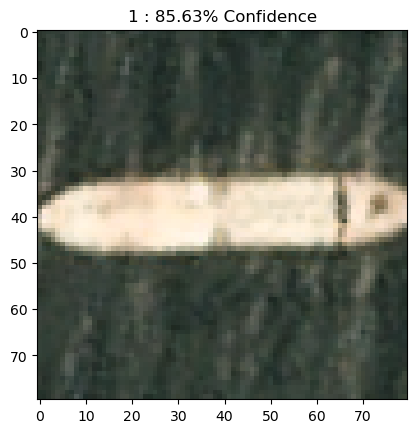

In [23]:
plt.figure()
plt.imshow(examples[5])
confidence = model(np.reshape(examples[0], [1,80,80,3])).numpy()[0,0]
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()

In [24]:
loss_object = tf.keras.losses.BinaryCrossentropy()
signed_grad_np = create_adversarial_pattern(model, np.reshape(examples[5], [1,80,80,3]), np.array([[0]]), loss_object)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


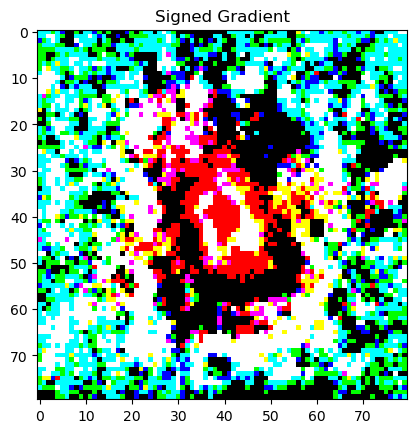

In [25]:
plt.figure()
plt.imshow(signed_grad_np[0])
plt.title('Signed Gradient')
plt.show()

4. Evaluate the white-box, targeted (targeting 0) FGSM adversarial examples for a ship test set example for the non-linear classification model using epsilons of 0.01, 0.03, and 0.1.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


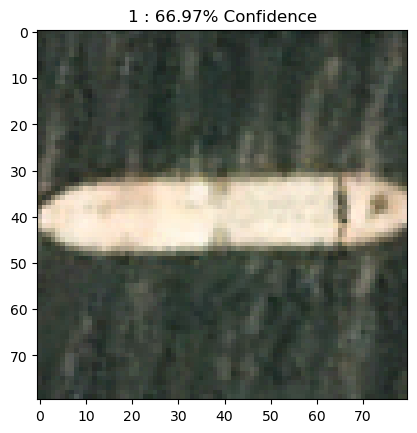

In [26]:
#Epsilon: 0.01
plt.figure()
adv_example = examples[5]-signed_grad_np[0]*0.01
plt.imshow(np.clip(adv_example,0,255))
confidence = model(np.reshape(adv_example, [1,80,80,3])).numpy()[0,0]
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


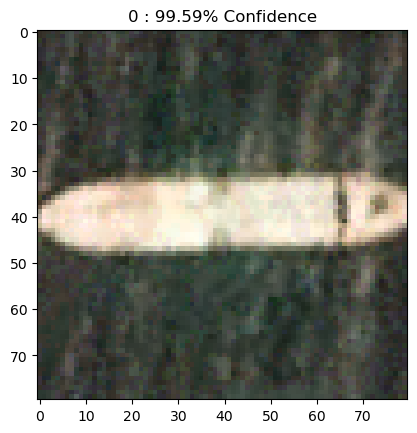

In [27]:
#Epsilon: 0.03
plt.figure()
adv_example = examples[5]-signed_grad_np[0]*0.03
plt.imshow(np.clip(adv_example,0,255))
confidence = model(np.reshape(adv_example,[1,80,80,3])).numpy()[0,0]
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


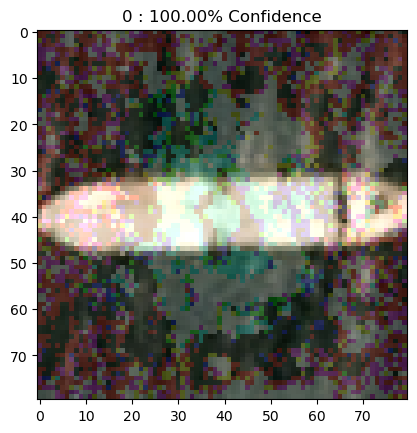

In [28]:
#Epsilon: 0.1
plt.figure()
adv_example = examples[5]-signed_grad_np[0]*0.1
plt.imshow(np.clip(adv_example,0,255))
confidence = model(np.reshape(adv_example,[1,80,80,3])).numpy()[0,0]
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()

5. Create a black-box, targeted (targeting 0) FGSM adversarial example for a ship test set example for the original non-linear classification model using an epsilon of 0.04.

In [29]:
inputs_bb = layers.Input(shape=(80,80,3))
flat_bb = layers.Flatten()(inputs_bb)
h1_bb = layers.Dense(50, activation="relu")(flat_bb)
h2_bb = layers.Dense(50, activation="relu")(h1_bb)
p_bb = layers.Dense(1,activation=tf.keras.activations.sigmoid)(h2_bb)

model_bb = keras.Model(inputs=inputs_bb, outputs=p_bb)

model_bb.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(LR),
    metrics=[tf.keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.BinaryCrossentropy(from_logits=False)]
)

In [30]:
model_bb.fit(train_dataset, epochs=n_epochs, verbose=True)

Epoch 1/200
4/4 [==============================] - 1s 17ms/step - loss: 1.0548 - binary_accuracy: 0.4366 - binary_crossentropy: 1.0548
Epoch 2/200
4/4 [==============================] - 0s 16ms/step - loss: 0.8225 - binary_accuracy: 0.7747 - binary_crossentropy: 0.8225
Epoch 3/200
4/4 [==============================] - 0s 16ms/step - loss: 0.5464 - binary_accuracy: 0.7725 - binary_crossentropy: 0.5464
Epoch 4/200
4/4 [==============================] - 0s 16ms/step - loss: 0.4483 - binary_accuracy: 0.8150 - binary_crossentropy: 0.4483
Epoch 5/200
4/4 [==============================] - 0s 16ms/step - loss: 0.4147 - binary_accuracy: 0.8328 - binary_crossentropy: 0.4147
Epoch 6/200
4/4 [==============================] - 0s 16ms/step - loss: 0.4100 - binary_accuracy: 0.8238 - binary_crossentropy: 0.4100
Epoch 7/200
4/4 [==============================] - 0s 16ms/step - loss: 0.3752 - binary_accuracy: 0.8356 - binary_crossentropy: 0.3752
Epoch 8/200
4/4 [==============================] - 0s 1

4/4 [==============================] - 0s 16ms/step - loss: 0.2422 - binary_accuracy: 0.9056 - binary_crossentropy: 0.2422
Epoch 62/200
4/4 [==============================] - 0s 16ms/step - loss: 0.2498 - binary_accuracy: 0.9019 - binary_crossentropy: 0.2498
Epoch 63/200
4/4 [==============================] - 0s 16ms/step - loss: 0.2585 - binary_accuracy: 0.8972 - binary_crossentropy: 0.2585
Epoch 64/200
4/4 [==============================] - 0s 16ms/step - loss: 0.2643 - binary_accuracy: 0.8934 - binary_crossentropy: 0.2643
Epoch 65/200
4/4 [==============================] - 0s 16ms/step - loss: 0.2652 - binary_accuracy: 0.8953 - binary_crossentropy: 0.2652
Epoch 66/200
4/4 [==============================] - 0s 16ms/step - loss: 0.2544 - binary_accuracy: 0.8956 - binary_crossentropy: 0.2544
Epoch 67/200
4/4 [==============================] - 0s 16ms/step - loss: 0.2305 - binary_accuracy: 0.9062 - binary_crossentropy: 0.2305
Epoch 68/200
4/4 [==============================] - 0s 16ms/s

4/4 [==============================] - 0s 16ms/step - loss: 0.1489 - binary_accuracy: 0.9438 - binary_crossentropy: 0.1489
Epoch 122/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1474 - binary_accuracy: 0.9416 - binary_crossentropy: 0.1474
Epoch 123/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1465 - binary_accuracy: 0.9441 - binary_crossentropy: 0.1465
Epoch 124/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1453 - binary_accuracy: 0.9431 - binary_crossentropy: 0.1453
Epoch 125/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1440 - binary_accuracy: 0.9456 - binary_crossentropy: 0.1440
Epoch 126/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1426 - binary_accuracy: 0.9438 - binary_crossentropy: 0.1426
Epoch 127/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1409 - binary_accuracy: 0.9447 - binary_crossentropy: 0.1409
Epoch 128/200
4/4 [==============================] - 0s

4/4 [==============================] - 0s 16ms/step - loss: 0.1007 - binary_accuracy: 0.9666 - binary_crossentropy: 0.1007
Epoch 181/200
4/4 [==============================] - 0s 16ms/step - loss: 0.0875 - binary_accuracy: 0.9706 - binary_crossentropy: 0.0875
Epoch 182/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1194 - binary_accuracy: 0.9538 - binary_crossentropy: 0.1194
Epoch 183/200
4/4 [==============================] - 0s 16ms/step - loss: 0.0920 - binary_accuracy: 0.9681 - binary_crossentropy: 0.0920
Epoch 184/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1175 - binary_accuracy: 0.9531 - binary_crossentropy: 0.1175
Epoch 185/200
4/4 [==============================] - 0s 16ms/step - loss: 0.0957 - binary_accuracy: 0.9653 - binary_crossentropy: 0.0957
Epoch 186/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1281 - binary_accuracy: 0.9506 - binary_crossentropy: 0.1281
Epoch 187/200
4/4 [==============================] - 0s

In [31]:
signed_grad_np_bb = create_adversarial_pattern(model_bb, np.reshape(examples[5], [1,80,80,3]), np.array([[0]]), loss_object)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


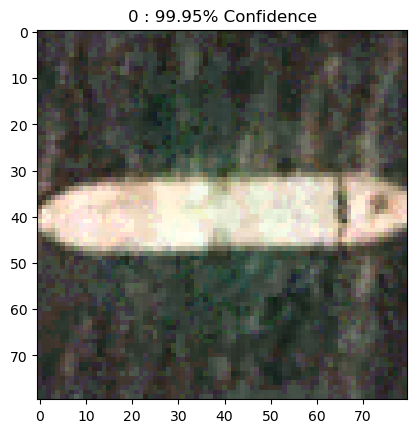

In [32]:
plt.figure()
adv_example_bb = examples[5]-signed_grad_np_bb[0]*0.04
plt.imshow(np.clip(adv_example_bb,0,255))
confidence = model_bb(np.reshape(adv_example_bb,[1,80,80,3])).numpy()[0,0]
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()

6. Evaluate black-box, targeted (targeting 0) FGSM adversarial examples for a ship test set example for the non-linear classification model.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


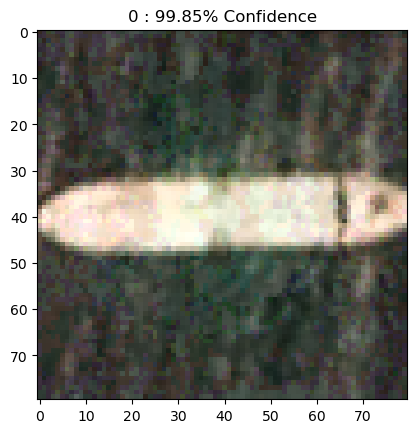

In [33]:
plt.figure()
plt.imshow(np.clip(adv_example_bb,0,255))
confidence = model(np.reshape(adv_example_bb,[1,80,80,3])).numpy()[0,0]
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()